# A short tutorial on Fuzzy Time Series - Part III (Interval and Probabilistic Forecasting and Non-stationary methods)

[MINDS - Machine Intelligence and Data Science Lab  ](http://www.minds.eng.ufmg.br/)

Petrônio C.  L. Silva, Rodrigo C. P. Silva, Marcos A. Alves, Carlos A. Severiano Jr.,   Gustavo L. Vieira, Frederico G. Guimarães, Hossein J. Sadaei

<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>


## Environment Setup

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /private/var/folders/ck/hjxynrwd7f74cn88t3sb1_j80000gn/T/pip-req-build-i1k_5xb3
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /private/var/folders/ck/hjxynrwd7f74cn88t3sb1_j80000gn/T/pip-req-build-i1k_5xb3
  Resolved https://github.com/PYFTS/pyFTS to commit 4c77ecc73fa0888132ac3996ca7e1f519dcf2fc8
  Preparing metadata (setup.py) ... done


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns


from pyFTS.common import Util

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = pd.read_csv('https://query.data.world/s/6xfb5useuotbbgpsnm5b2l3wzhvw2i', sep=';')

train_uv = data['glo_avg'].values[:9000]
test_uv = data['glo_avg'].values[9000:9100]

train_mv = data.iloc[:9000]
test_mv = data.iloc[9000:9100]

del(data)

## Interval and Probabilistic Forecasting

### Interval Forecasting methods

#### Univariate Methods

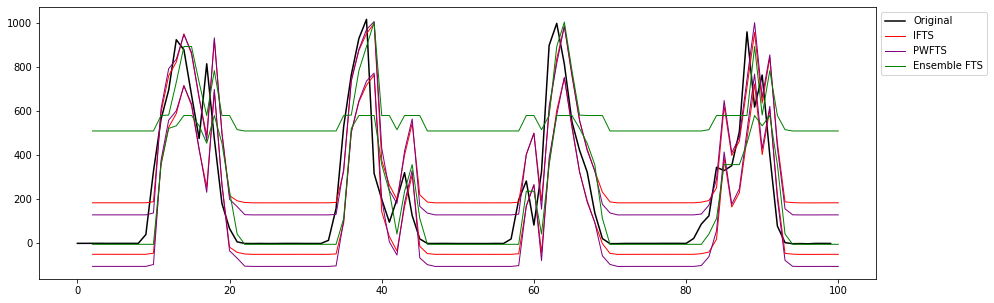

In [6]:
from pyFTS.partitioners import Grid
from pyFTS.models import ifts, pwfts
from pyFTS.models.ensemble import ensemble
from pyFTS.common import Util
from pyFTS.benchmarks import Measures

rows = []
colors = ['red', 'purple', 'green']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(test_uv, label='Original',color='black')

part = Grid.GridPartitioner(data=train_uv, npart=11)

for ct, method in enumerate([ifts.IntervalFTS, pwfts.ProbabilisticWeightedFTS, ensemble.AllMethodEnsembleFTS]):
  model = method(partitioner=part, order=2)
  model.fit(train_uv)
  forecasts = model.predict(test_uv, type='interval', alpha=0.05)
  
  sharp, res, cov, _, _, _, _, winkler05, _ = Measures.get_interval_statistics(test_uv, model)
  
  rows.append([model.shortname, sharp, res, cov, winkler05])

  Util.plot_interval(ax, forecasts, model.order, model.shortname, colors[ct])
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [7]:
rows

[['IFTS', 234.39, 0.0, 0.74, 1737.12],
 ['PWFTS', 234.39, 0.0, 0.73, 1792.55],
 ['Ensemble FTS', 411.22, 127.62, 0.68, 2356.95]]

#### Multivariate Methods

In [8]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Fev','Mar','Abr','Mai','Jun','Jul', 'Ago','Set','Out','Nov','Dez']}

vmonth = variable.Variable("Month", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train_mv, partitioner_specific=sp)

sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k) for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_mv, partitioner_specific=sp)

vavg = variable.Variable("Radiation", data_label="glo_avg", alias='rad',
                         partitioner=Grid.GridPartitioner, npart=11, alpha_cut=.0, 
                         data=train_mv) 



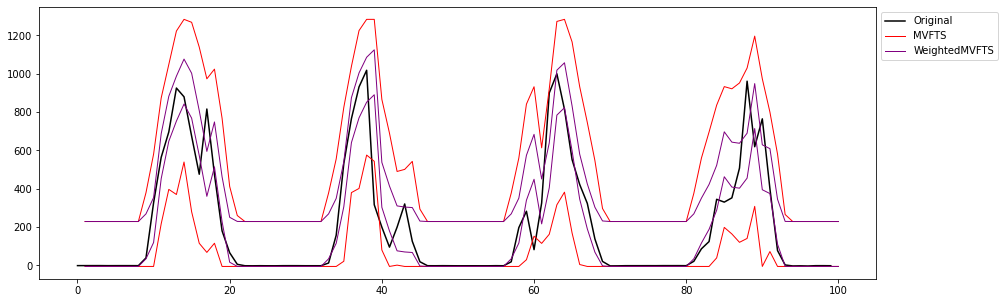

In [9]:
from pyFTS.models.multivariate import mvfts, wmvfts
from pyFTS.common import Util
from pyFTS.benchmarks import Measures

rows = []
colors = ['red', 'purple', 'green']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(test_uv, label='Original',color='black')

for ct, method in enumerate([mvfts.MVFTS, wmvfts.WeightedMVFTS]):
  model = method(explanatory_variables=[vmonth, vhour, vavg], target_variable=vavg)
  model.fit(train_mv)
  forecasts = model.predict(test_mv, type='interval', alpha=0.05)
  
  #sharp, res, cov, _, _, _, _, winkler05, _ = Measures.get_interval_statistics(test_mv, model)
  
  #rows.append([model.shortname, sharp, res, cov, winkler05])

  Util.plot_interval(ax, forecasts, model.order, model.shortname, colors[ct])
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

### Probabilistic Forecasting

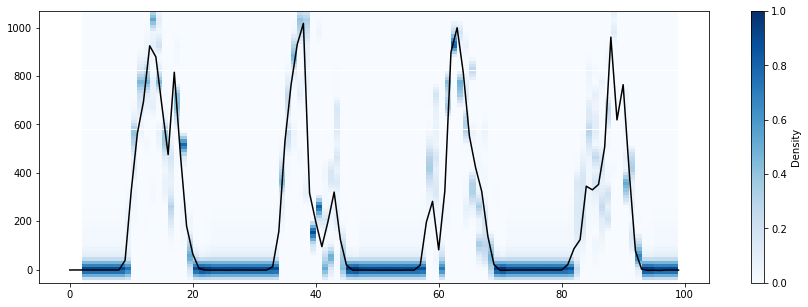

In [8]:
from pyFTS.partitioners import Grid
from pyFTS.models import pwfts
from pyFTS.models.ensemble import ensemble
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt

rows = []
colors = ['red', 'purple', 'green']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(test_uv, label='Original',color='black')

part = Grid.GridPartitioner(data=train_uv, npart=25)

model = pwfts.ProbabilisticWeightedFTS(partitioner=part, order=3)
model.fit(train_uv)
distributions = model.predict(test_uv, type='distribution')

Util.plot_distribution(ax, "Blues", distributions[:-1], fig, model.order-1)


NameError: name 'distributions' is not defined

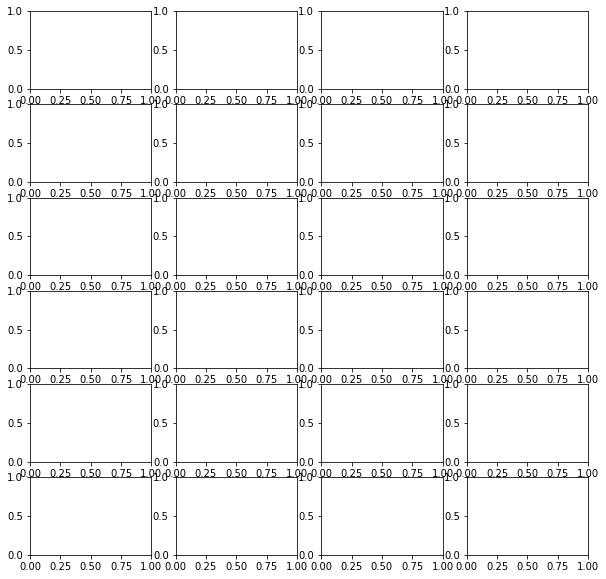

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=4,figsize=[10,10])

row = 0
col = 0
for hour in range(0,24):
  distributions[hour].plot(ax[row][col])
  ax[row][col].set_title('{}h'.format(hour))
  
  col = (hour+1) % 4
  row = (hour+1) // 4 

plt.tight_layout()

In [ ]:
from pyFTS.partitioners import Grid
from pyFTS.models.ensemble import ensemble
from pyFTS.common import Util
from pyFTS.benchmarks import Measures

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(test_uv, label='Original',color='black')

part = Grid.GridPartitioner(data=train_uv, npart=35)

model = ensemble.AllMethodEnsembleFTS(partitioner=part, order=3)
model.fit(train_uv)
distributions = model.predict(test_uv, type='distribution', alpha=.1)

Util.plot_distribution(ax, "Blues", distributions[:-1], fig, model.order-1)


In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=4,figsize=[10,10])

row = 0
col = 0
for hour in range(0,24):
  distributions[hour].plot(ax[row][col])
  ax[row][col].set_title('{}h'.format(hour))
  
  col = (hour+1) % 4
  row = (hour+1) // 4 

plt.tight_layout()

## Non-stationarity and Concept Drifts

### Transformations

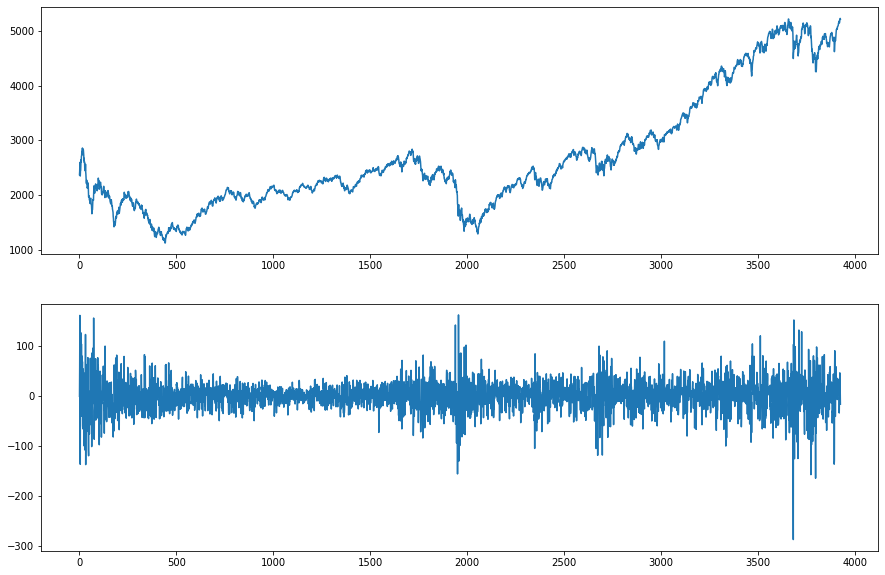

In [11]:
from pyFTS.data import NASDAQ
from pyFTS.common import Transformations

diff = Transformations.Differential(1)

data = NASDAQ.get_data()

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[15,10])

ax[0].plot(data)
ax[1].plot(diff.apply(data))

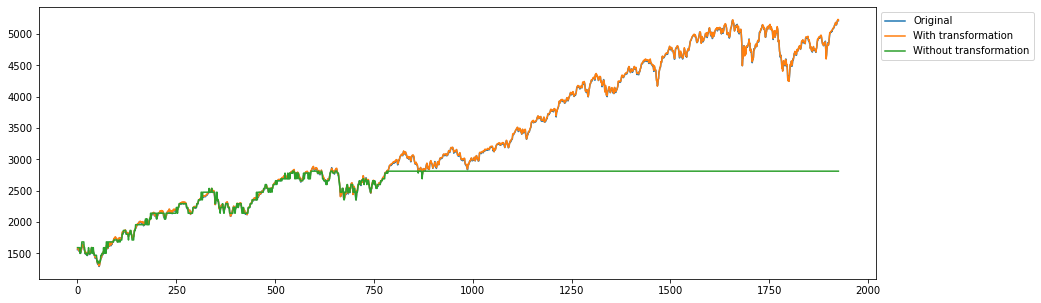

In [12]:
from pyFTS.models import chen
from pyFTS.partitioners import Grid

train = data[:2000]
test = data[2000:]

part1 = Grid.GridPartitioner(data=train, npart=15, transformation=diff)
part2 = Grid.GridPartitioner(data=train, npart=35)

model1 = chen.ConventionalFTS(partitioner=part1)
model1.append_transformation(diff)
model1.fit(train)

model2 = chen.ConventionalFTS(partitioner=part2)
model2.fit(train)

forecasts1 = model1.predict(test)
forecasts2 = model2.predict(test)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(test, label='Original')
ax.plot(forecasts1, label='With transformation')
ax.plot(forecasts2, label='Without transformation')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

### Creating artificial time series with concept drifts

In [13]:
from pyFTS.data import artificial

mu_local = 5
sigma_local = 0.25
mu_drift = 10
sigma_drift = 2
deflen = 100
totlen = deflen * 10
order = 10

window = 100
batch = 10

num_models = 3

def mavg(l,order=10):
  ret = [] 
  for k in np.arange(order, len(l)):
    ret.append( np.nanmean(l[k-order:k])  )
    
  return ret

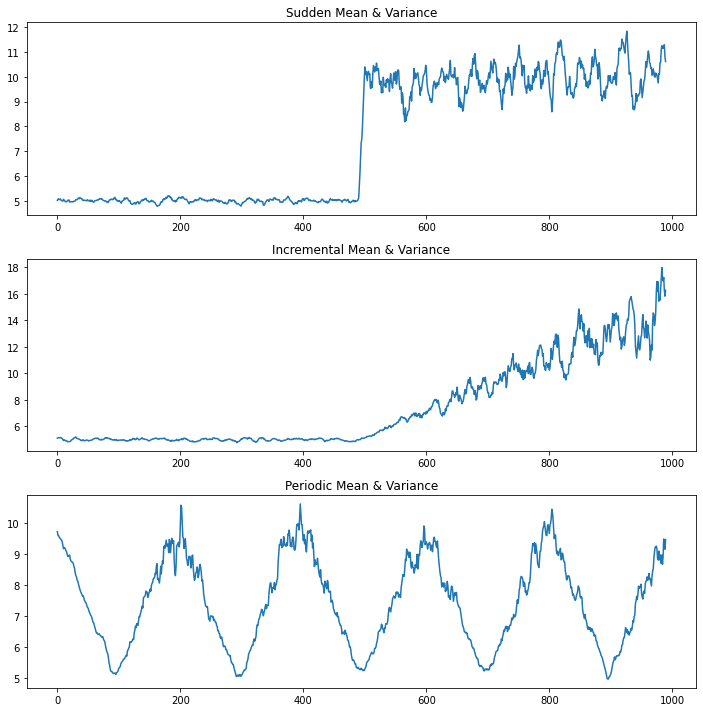

In [14]:
from pyFTS.data import artificial

signals = {}

signals['Sudden Mean & Variance'] = artificial.SignalEmulator()\
.stationary_gaussian(mu_local,sigma_local,length=deflen//2,it=10)\
.stationary_gaussian(mu_drift,sigma_drift,length=deflen//2,it=10, additive=False)\
.run()

signals['Incremental Mean & Variance'] = artificial.SignalEmulator()\
.stationary_gaussian(mu_local,sigma_local,length=deflen,it=10)\
.incremental_gaussian(0.02,0.01,length=totlen//2,start=totlen//2)\
.run()

signals['Periodic Mean & Variance'] = artificial.SignalEmulator()\
.stationary_gaussian(mu_local,sigma_local,length=deflen,it=10)\
.periodic_gaussian('linear',100,mu_local,sigma_local,mu_drift,sigma_drift,length=totlen,start=0)\
.run()


fig, ax = plt.subplots(nrows=len(signals), ncols=1, figsize=[10,10])

for count, key in enumerate(signals.keys()):
  signal = mavg(signals[key])
  ax[count].plot(signal, label='original')
  ax[count].set_title(key)
  
plt.tight_layout()
  

### Time Variant Methods

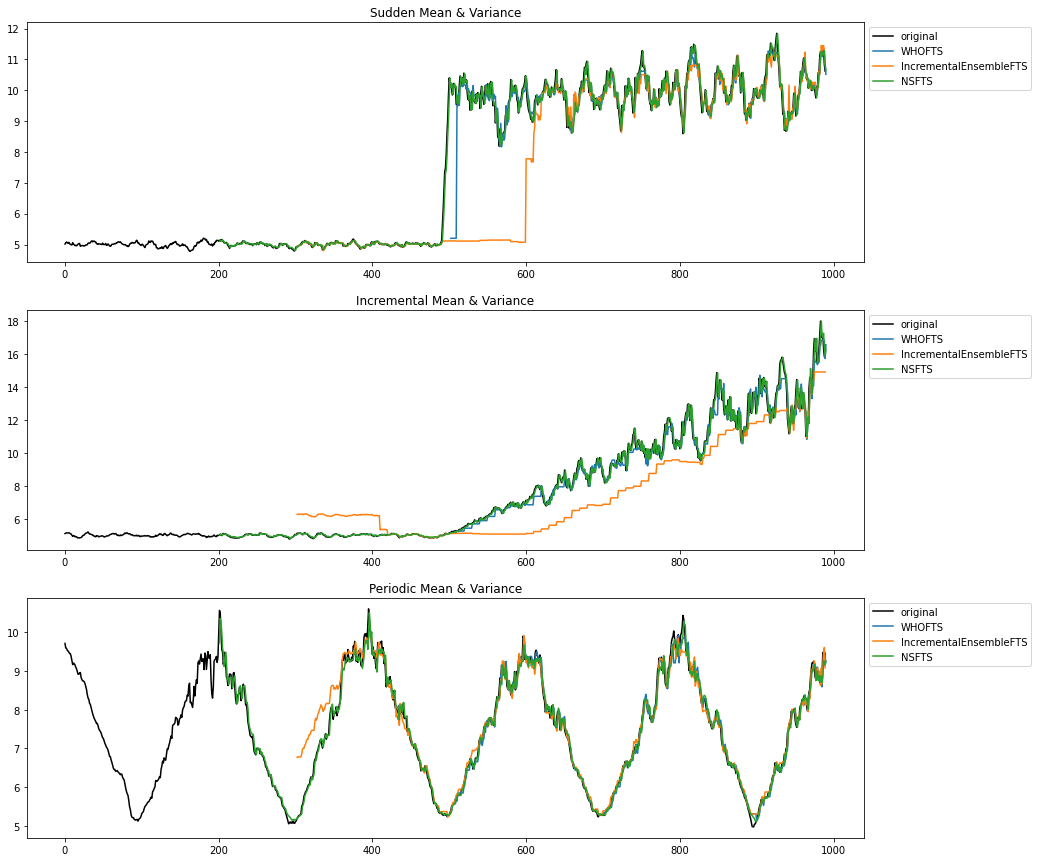

In [15]:
from pyFTS.models.incremental import TimeVariant, IncrementalEnsemble
from pyFTS.models.nonstationary import common, perturbation, partitioners as nspart
from pyFTS.models.nonstationary import nsfts, util as nsUtil
from pyFTS.partitioners import Grid
from pyFTS.models import hofts

model1 = TimeVariant.Retrainer(partitioner_method=Grid.GridPartitioner, partitioner_params={'npart': 35},
                              fts_method=hofts.WeightedHighOrderFTS, fts_params={}, order=2 ,
                              batch_size=batch, window_length=window*num_models)

model2 = IncrementalEnsemble.IncrementalEnsembleFTS(partitioner_method=Grid.GridPartitioner, partitioner_params={'npart': 35},
                              fts_method=hofts.WeightedHighOrderFTS, fts_params={}, order=2 ,
                              batch_size=batch, window_length=window, num_models=num_models)


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[15,15])

for count, key in enumerate(signals.keys()):
  signal = mavg(signals[key])
  ax[count].plot(signal, color='black', label='original')
  ax[count].set_title(key)
  
  train = signal[:200]
  test = signal[200:]
  
  nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=train, npart=35, transformation=None)
  model3 = nsfts.NonStationaryFTS(partitioner=nsfs)

  
  for model in [model1, model2, model3]:
    model.fit(train)
    forecasts = model.predict(test)
    for k in range(model.max_lag+200):
      forecasts.insert(0,None)

    ax[count].plot(forecasts, label=model.shortname)
    
  handles, labels = ax[count].get_legend_handles_labels()
  lgd = ax[count].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

